In [1]:
import numpy as np
import string
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
def parseData(file, read_limit):
    null = None
    with open(file, errors='ignore') as f:
        i=0
        for l in f:
            if i<read_limit:
                i+=1
                yield eval(l)
            else:
                break
            
def LoadData(f, read_limit = 200000):
    return list(parseData(f, read_limit))

business_data = LoadData('yelp_academic_dataset_business.json')
review_data = LoadData('yelp_academic_dataset_review.json')
tip_data = LoadData('yelp_academic_dataset_tip.json')

In [5]:
cat_dict = defaultdict(int)
biz_cat_map = defaultdict(list)
for data in business_data:
    if data['categories'] != None:
        biz_cat_map[data['business_id']] = data['categories']
        for cat  in data['categories']:
            cat_dict[cat]+=1

In [6]:
len(biz_cat_map)

143747

In [7]:
years = [d['date'].split('-')[0] for d in review_data]
hist  = Counter(years)
x_year=[]
y_freq=[]
for year in range(int(min(years)), int(max(years))+1):
    x_year.append(year)
    y_freq.append(hist[str(year)])

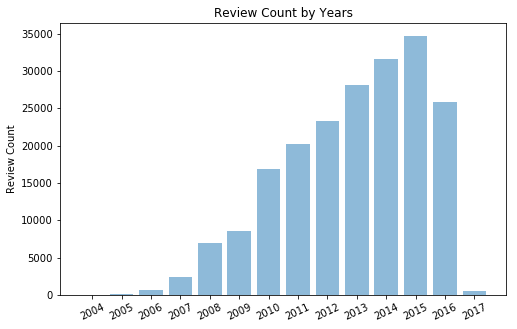

<function matplotlib.pyplot.savefig>

In [8]:
#plt.bar(np.arange(len(hist)), hist, align='center')
y_pos = np.arange(len(x_year))
 
plt.figure( figsize=(8,5))
plt.bar(y_pos, y_freq, align='center', alpha=0.5)
plt.xticks(y_pos, x_year, rotation='25')
plt.ylabel('Review Count')
plt.title('Review Count by Years')
plt.show()
plt.savefig

In [13]:

#data[0]['date'].split('-')[0]
sort_cat =  sorted(cat_dict.items(), key=lambda x:x[1])[-50:]
sort_cat.reverse()
sorted_cat = [d[0] for d in sort_cat]

In [15]:
sort_cat[:20]
x_cat = []
y_count = []
for cat in sort_cat[:10]:
    x_cat.append(cat[0])
    y_count.append(cat[1])

In [16]:
len(cat_dict)

1191

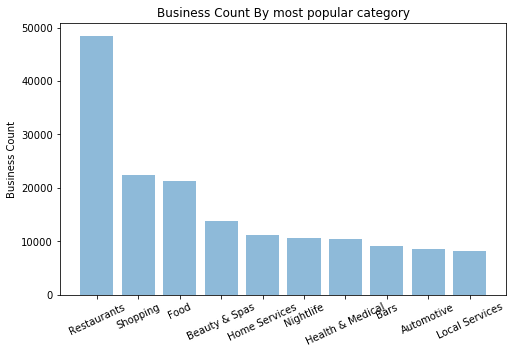

<function matplotlib.pyplot.savefig>

In [17]:
y_pos = np.arange(len(x_cat))
 
plt.figure(figsize=(8,5))
plt.bar(y_pos, y_count, align='center', alpha=0.5)
plt.xticks(y_pos, x_cat, rotation='25')
plt.ylabel('Business Count')
plt.title('Business Count By most popular category')
plt.show()
plt.savefig

In [18]:
sorted_cat

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Nightlife',
 'Health & Medical',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'American (Traditional)',
 'Fast Food',
 'Pizza',
 'Sandwiches',
 'Coffee & Tea',
 'Hair Salons',
 'Hotels & Travel',
 'Arts & Entertainment',
 'Italian',
 'Auto Repair',
 'Home & Garden',
 'Burgers',
 'Mexican',
 'American (New)',
 'Chinese',
 'Doctors',
 'Breakfast & Brunch',
 'Nail Salons',
 'Specialty Food',
 'Fitness & Instruction',
 'Professional Services',
 'Real Estate',
 'Pets',
 'Grocery',
 'Bakeries',
 'Cafes',
 'Dentists',
 'Hotels',
 'Hair Removal',
 "Women's Clothing",
 'Desserts',
 'Skin Care',
 'Japanese',
 'Ice Cream & Frozen Yogurt',
 'Pubs',
 'Education',
 'Day Spas']

In [19]:
cat_count_arr=[]
for i in range(len(sort_cat)):
    cat_count_arr.append(sort_cat[i][1])

In [20]:
cat_count_arr = np.array(cat_count_arr)
y_range_count = []
ranges = [0, 50, 100, 200, 500, 1000, 2000, 5000, 10000,20000, 50000, 500000]
for i in range(0, len(ranges)-1):
    y_range_count.append(np.sum((cat_count_arr > ranges[i]) & (cat_count_arr<ranges[i+1])))

In [21]:
y_range_count

[0, 0, 0, 0, 0, 4, 28, 11, 4, 3, 0]

In [22]:
review_data[0]

{'business_id': '2aFiy99vNLklCx3T_tGS9A',
 'cool': 0,
 'date': '2011-10-10',
 'funny': 0,
 'review_id': 'NxL8SIC5yqOdnlXCg18IBg',
 'stars': 5,
 'text': "If you enjoy service by someone who is as competent as he is personable, I would recommend Corey Kaplan highly. The time he has spent here has been very productive and working with him educational and enjoyable. I hope not to need him again (though this is highly unlikely) but knowing he is there if I do is very nice. By the way, I'm not from El Centro, CA. but Scottsdale, AZ.",
 'type': 'review',
 'useful': 0,
 'user_id': 'KpkOkG6RIf4Ra25Lhhxf1A'}

In [23]:
business_data[0]

{'address': '227 E Baseline Rd, Ste J2',
 'attributes': ['BikeParking: True',
  'BusinessAcceptsBitcoin: False',
  'BusinessAcceptsCreditCards: True',
  "BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  'DogsAllowed: False',
  'RestaurantsPriceRange2: 2',
  'WheelchairAccessible: True'],
 'business_id': '0DI8Dt2PJp07XkVvIElIcQ',
 'categories': ['Tobacco Shops', 'Nightlife', 'Vape Shops', 'Shopping'],
 'city': 'Tempe',
 'hours': ['Monday 11:0-21:0',
  'Tuesday 11:0-21:0',
  'Wednesday 11:0-21:0',
  'Thursday 11:0-21:0',
  'Friday 11:0-22:0',
  'Saturday 10:0-22:0',
  'Sunday 11:0-18:0'],
 'is_open': 0,
 'latitude': 33.3782141,
 'longitude': -111.936102,
 'name': 'Innovative Vapors',
 'neighborhood': '',
 'postal_code': '85283',
 'review_count': 17,
 'stars': 4.5,
 'state': 'AZ',
 'type': 'business'}

In [24]:
Y_cat=[]
review_in_category = defaultdict(list)
review_by_id = defaultdict()
for data in review_data:
    biz_id = data['business_id']
    biz_cat = biz_cat_map[biz_id]
    revw_id = data['review_id']
    review_by_id[revw_id] = data['text']
    done = False
    if len(biz_cat) > 0: 
        for i in range(len(sorted_cat)):
            if sorted_cat[i] in biz_cat:
                Y_cat.append(i)
                review_in_category[sorted_cat[i]].append(revw_id)
                done = True
                break
        if done == False:
            Y_cat.append(len(sorted_cat))
            review_in_category['other'].append(revw_id)            

In [25]:
hist = Counter(Y_cat)
hist

Counter({0: 81128,
         1: 29134,
         2: 19979,
         3: 13755,
         4: 7761,
         5: 7913,
         6: 6629,
         8: 6007,
         9: 4053,
         10: 4557,
         11: 6874,
         19: 1854,
         20: 2879,
         33: 894,
         35: 2946,
         48: 692,
         50: 2584})

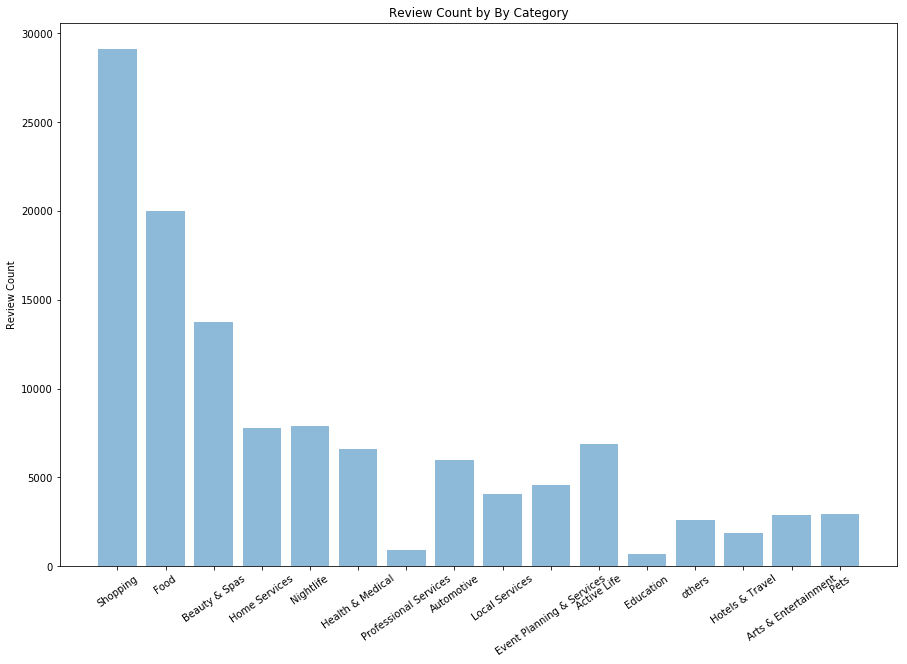

<function matplotlib.pyplot.savefig>

In [26]:
x_cat=[]
y_count=[]
for i in hist:
    if i == 0:
        continue
    if i!=len(sorted_cat):
        x_cat.append(sorted_cat[i])
        y_count.append(hist[i])
    else:
        x_cat.append('others')
        y_count.append(hist[i])
        
y_pos = np.arange(len(x_cat))
 
plt.figure( figsize=(15,10))
plt.bar(y_pos, y_count, align='center', alpha=0.5)
plt.xticks(y_pos, x_cat, rotation=35)
plt.ylabel('Review Count')
plt.title('Review Count by By Category')
plt.show()
plt.savefig

In [29]:
review_in_category['Fashion']

[]

Restaurants
Restaurants


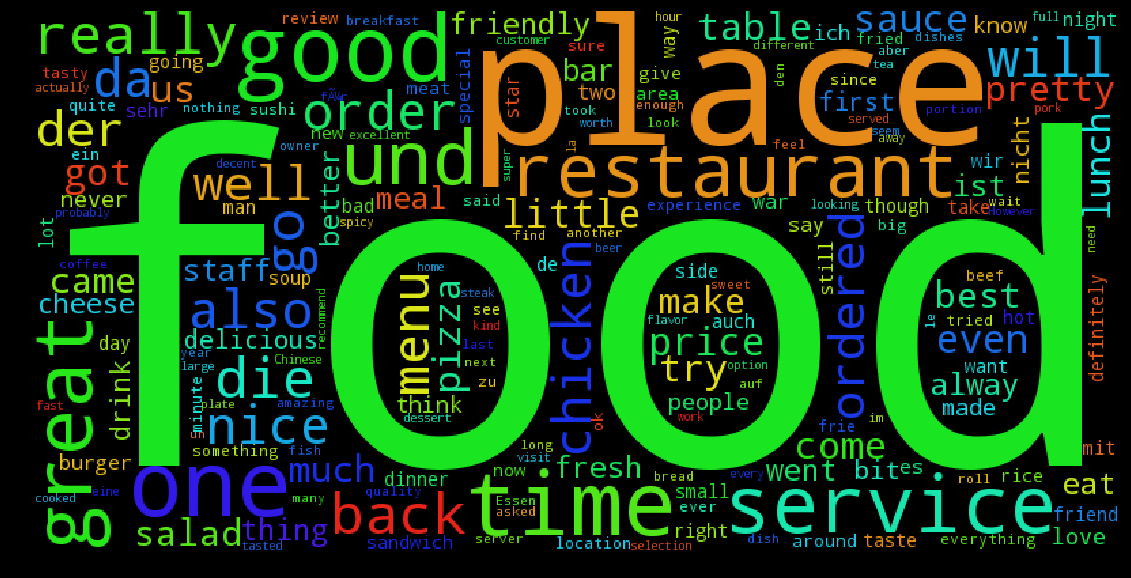

Shopping
Shopping


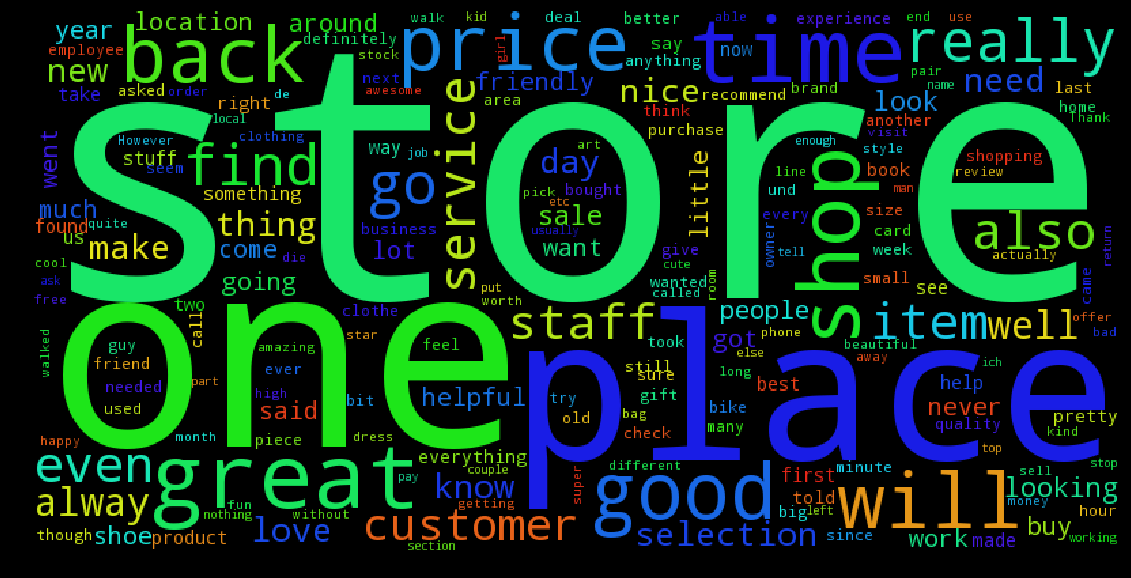

Food
Food


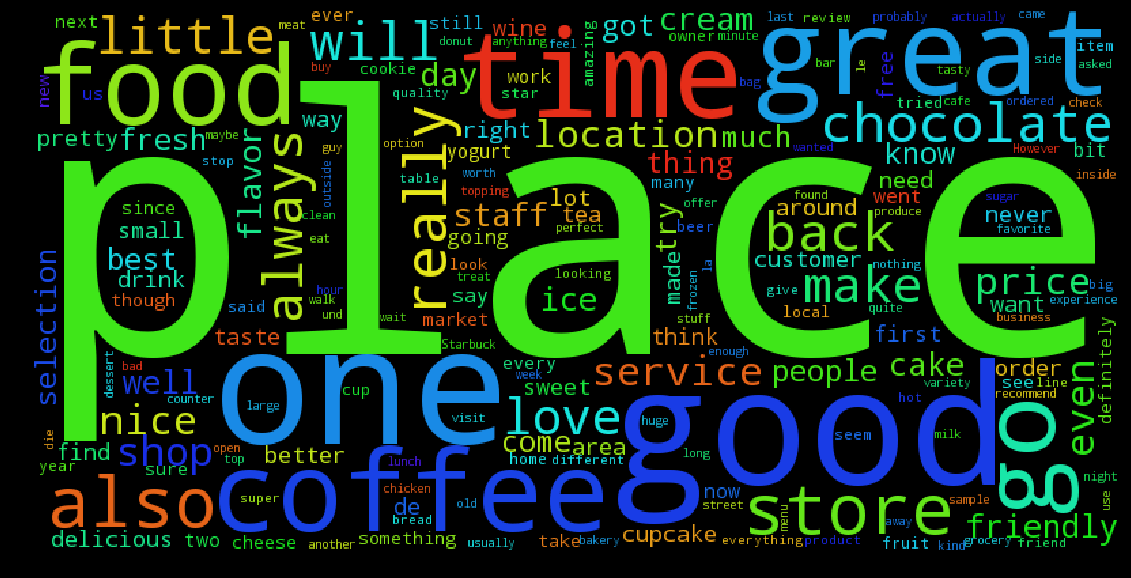

Beauty & Spas
Beauty & Spas


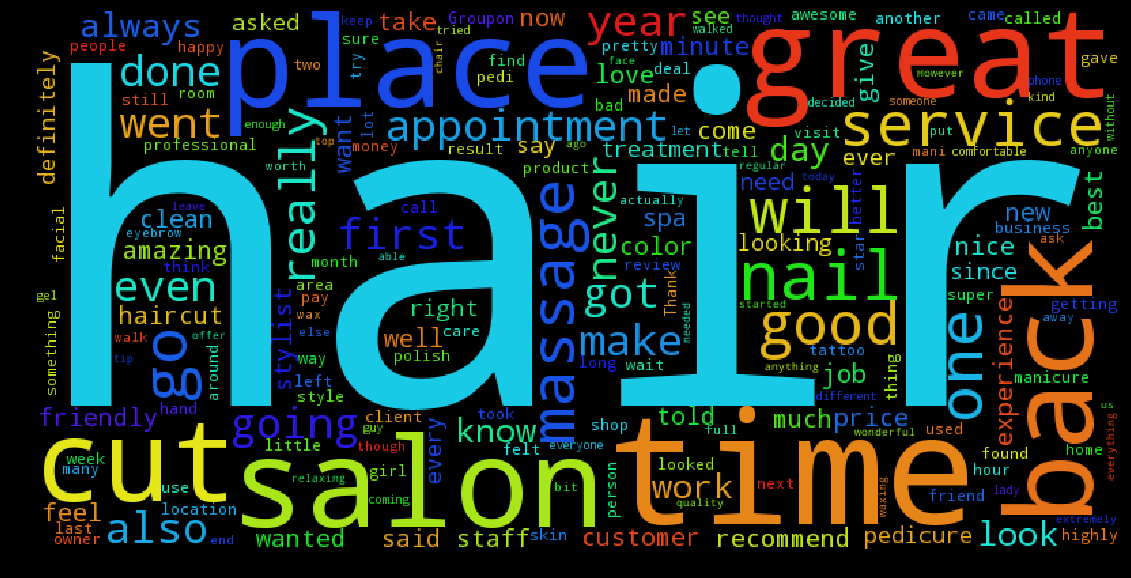

Home Services
Home Services


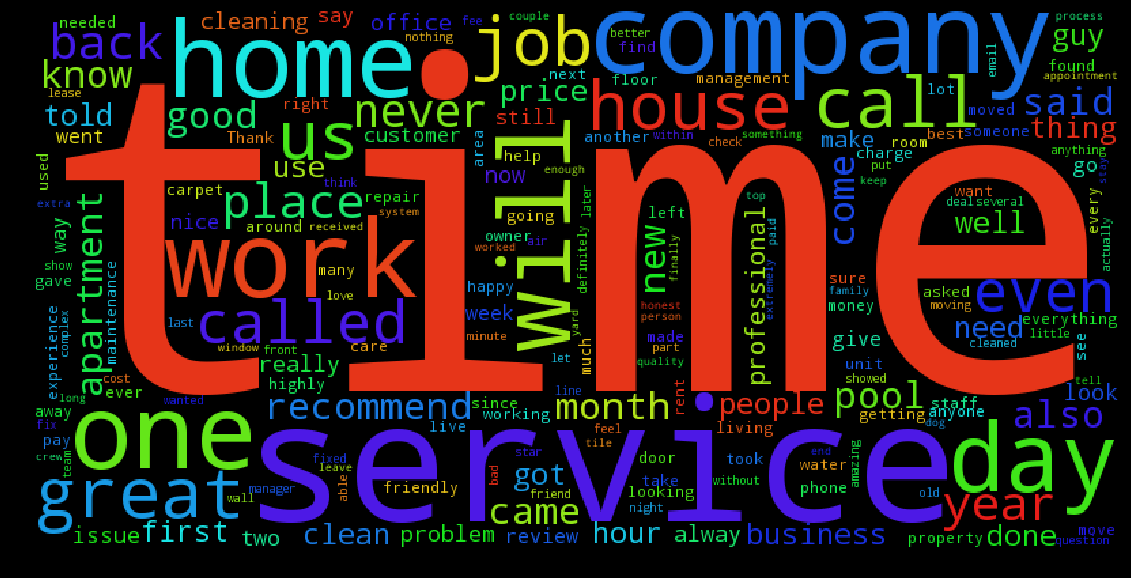

Nightlife
Nightlife


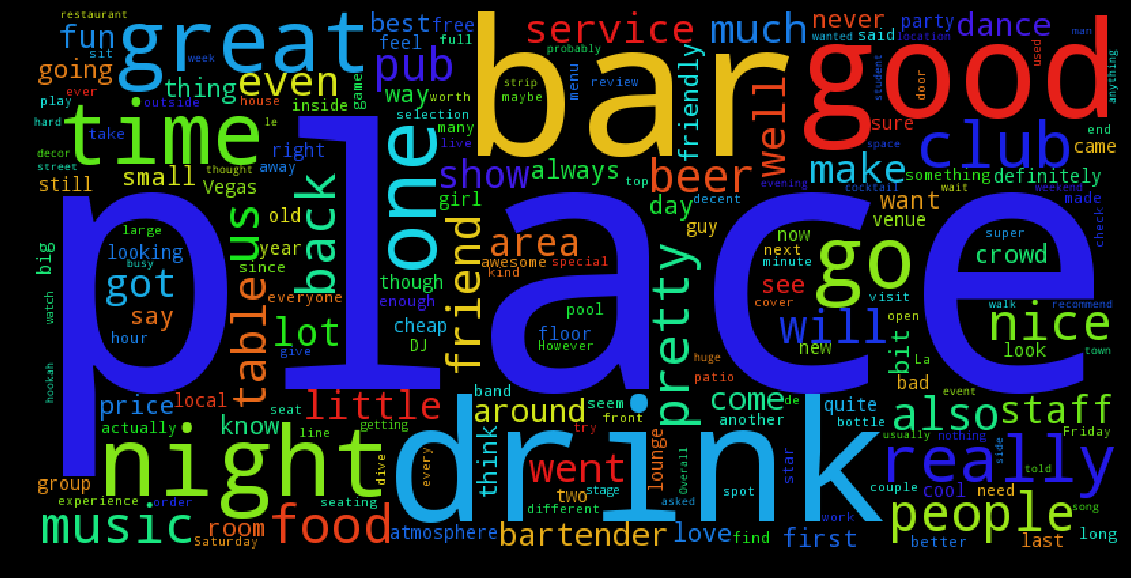

Health & Medical
Health & Medical


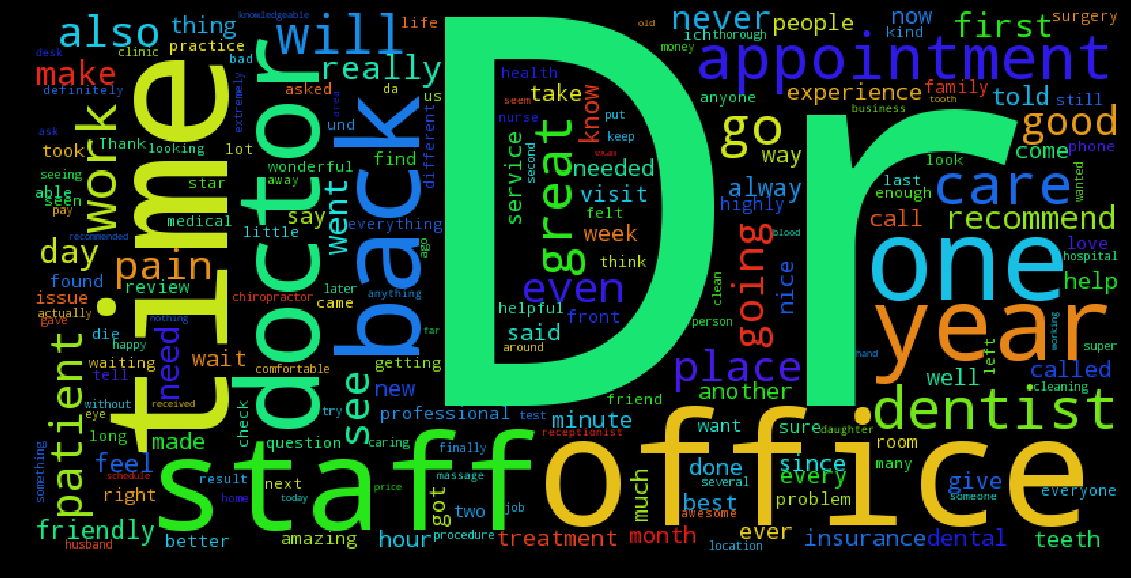

Bars
Automotive
Automotive


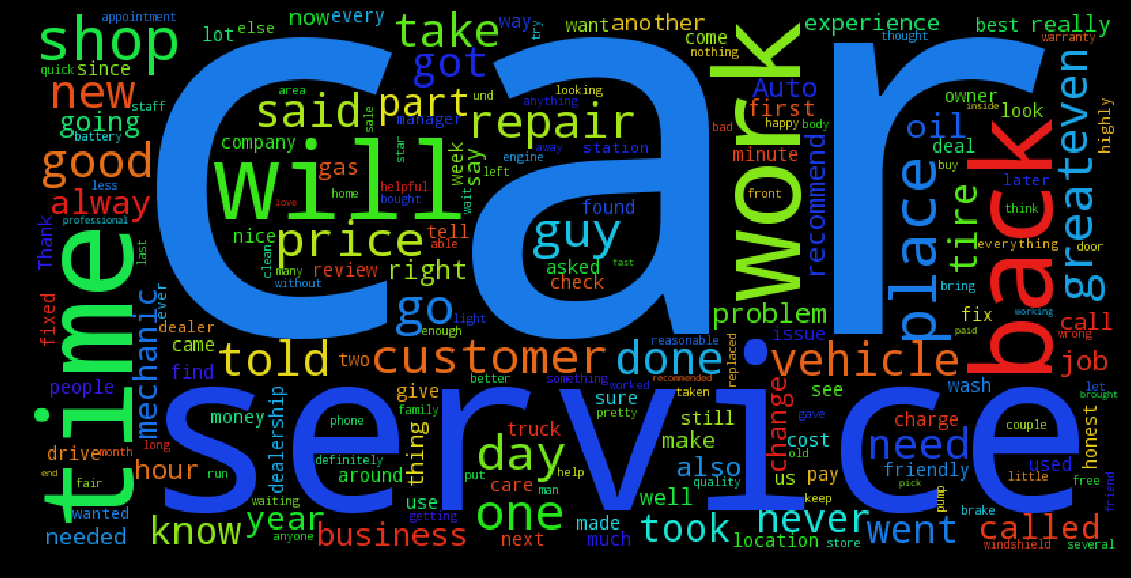

Local Services
Local Services


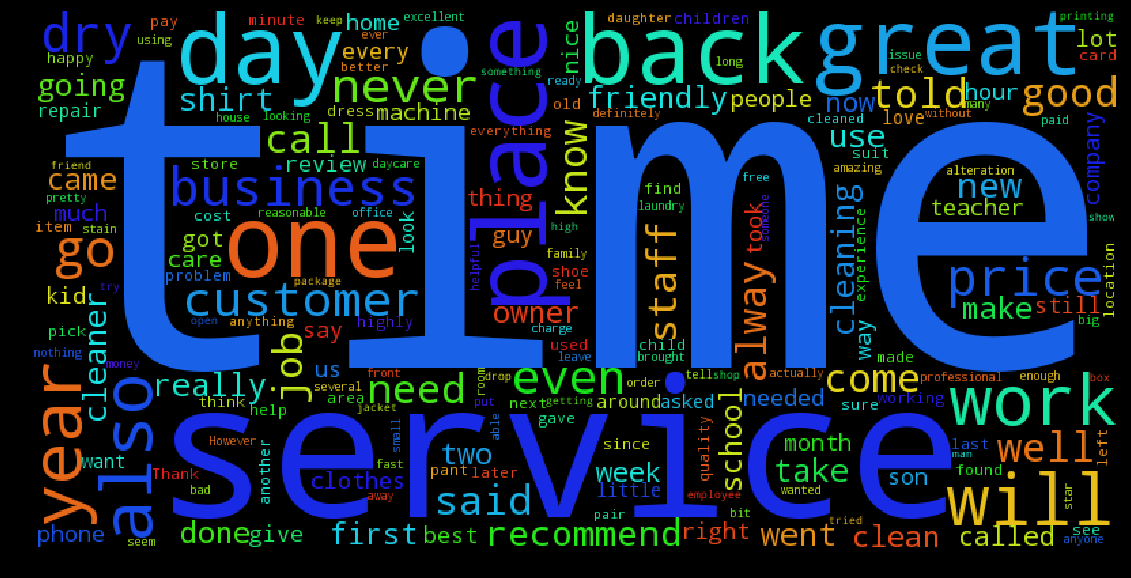

Event Planning & Services
Event Planning & Services


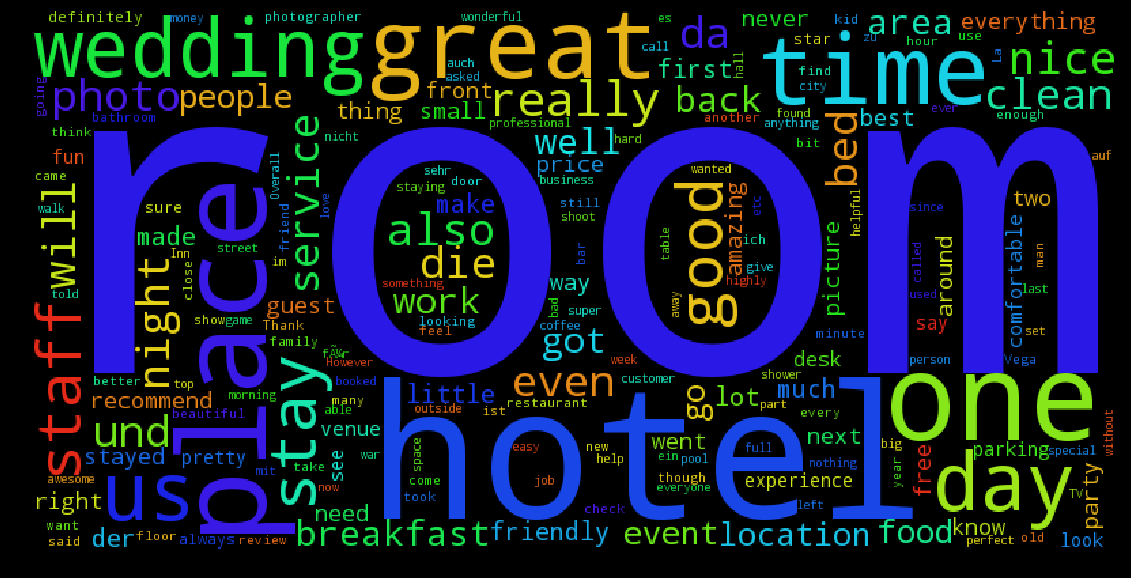

Active Life
Active Life


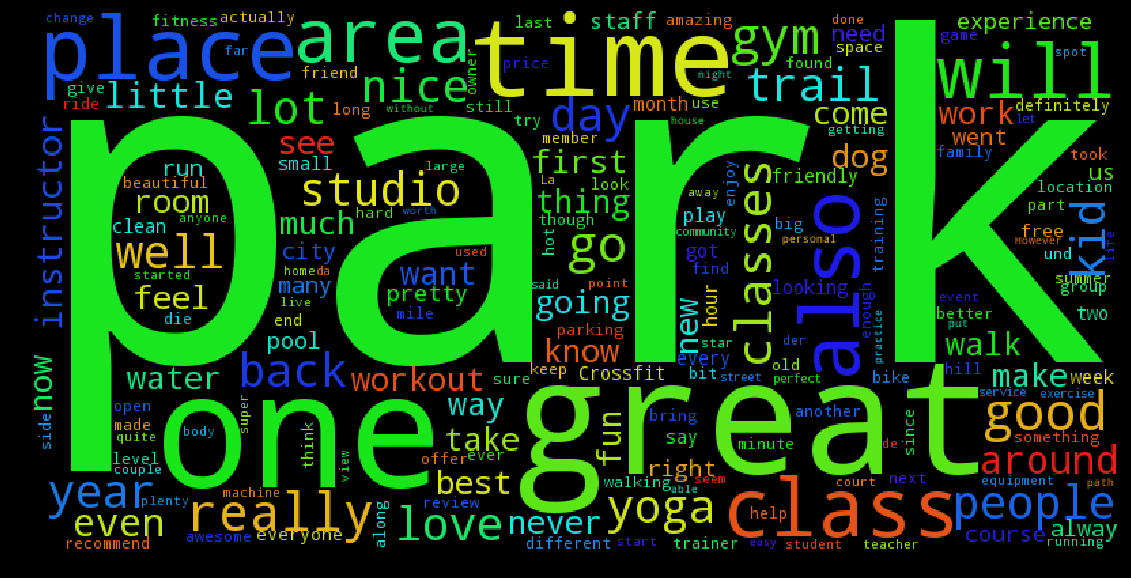

Fashion
American (Traditional)
Pizza
Fast Food
Sandwiches
Coffee & Tea
Arts & Entertainment
Arts & Entertainment


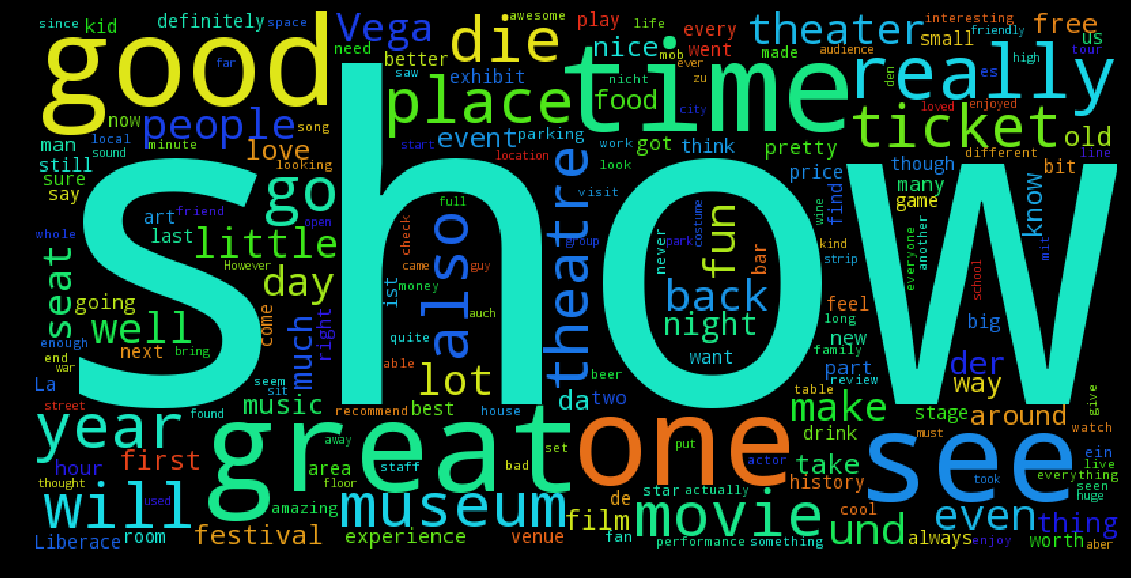

Hair Salons
Hotels & Travel
Hotels & Travel


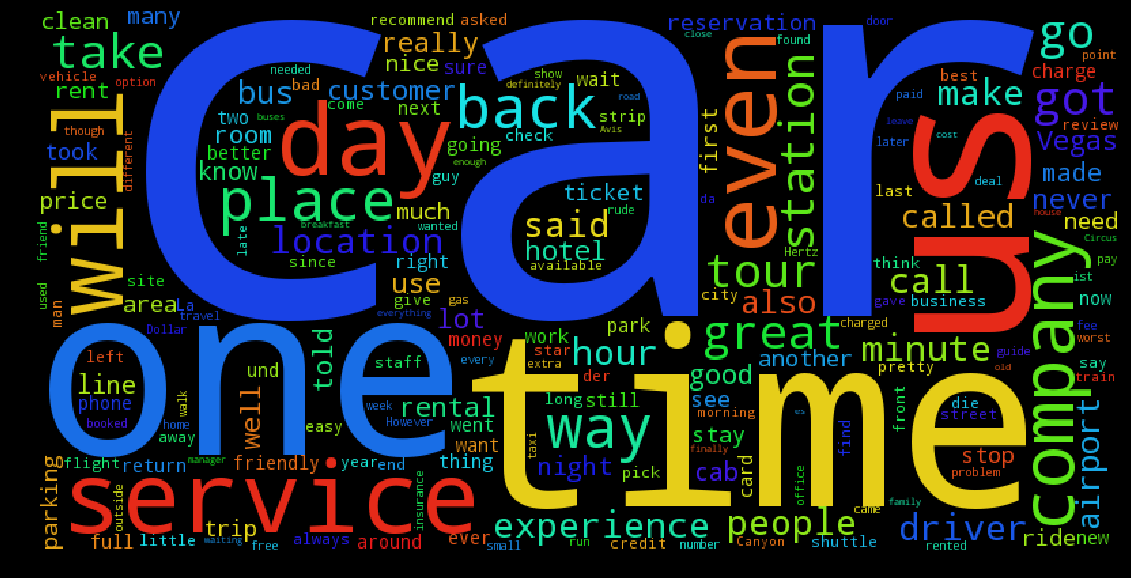

Italian
Home & Garden
Auto Repair
Burgers
Mexican
Chinese
American (New)
Doctors
Breakfast & Brunch
Nail Salons
Real Estate
Specialty Food
Fitness & Instruction
Professional Services
Professional Services


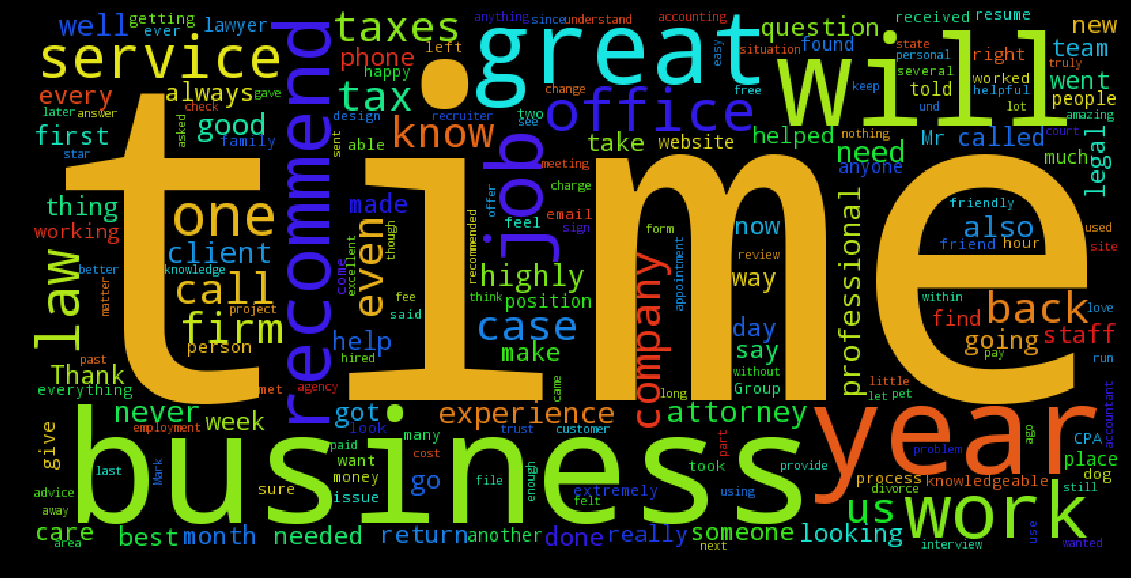

Pets
Pets


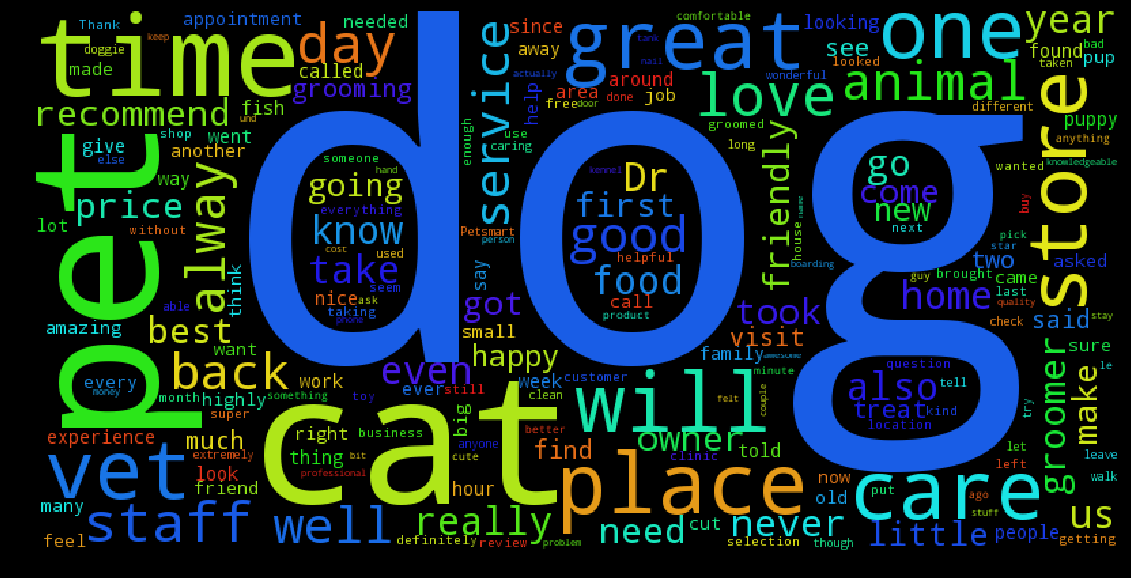

Grocery
Bakeries
Cafes
Dentists
Hotels
Hair Removal
Women's Clothing
Desserts
Skin Care
Japanese
Ice Cream & Frozen Yogurt
Day Spas
Pet Services
Pubs


In [272]:
n_feat = 100
from wordcloud import WordCloud
for cat in sorted_cat:
    print (cat)
    data_samples = [review_by_id[review_id] for review_id in review_in_category[cat]]
    if len(data_samples) > 0:
        print (cat)
        text = " ".join(data_samples)
    #tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_feat, stop_words='english')
    #tf = tf_vectorizer.fit_transform(data_samples)
    #nmf = NMF(n_components=1, random_state=1, alpha=.1, l1_ratio=.5).fit(tf)
        wordcloud = WordCloud(width=800, height=400).generate(text)
    # Open a plot of the generated image.
        plt.figure( figsize=(20,10), facecolor='k')
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        plt.savefig(cat+'.jpg', facecolor='k', bbox_inches='tight')
    

Restaurants
Shopping
Food
Beauty & Spas
Home Services
Nightlife
Health & Medical
Automotive
Local Services
Event Planning & Services
Active Life
Hotels & Travel
Arts & Entertainment
Professional Services
Pets
Education


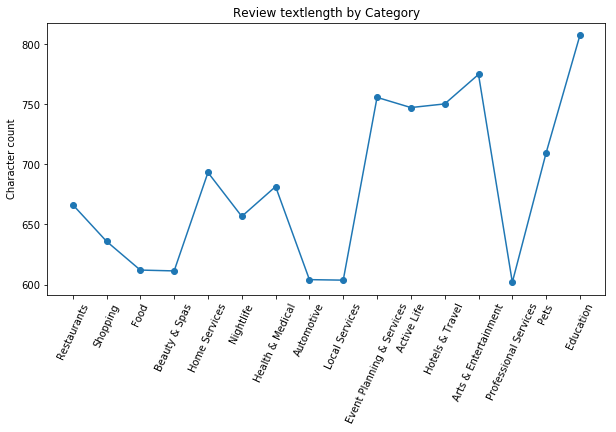

In [28]:
x_cat=[]
y_avg = []
for cat in sorted_cat:
    data_samples = [len(review_by_id[review_id]) for review_id in review_in_category[cat]]
    if len(data_samples) > 0:
        print (cat)
        x_cat.append(cat)
        y_avg.append(np.mean(data_samples))

y_pos = np.arange(len(x_cat))
 
plt.figure( figsize=(10,5))
plt.plot(y_pos, y_avg, marker='o')
plt.xticks(y_pos, x_cat, rotation=65)
plt.ylabel('Character count')
plt.title('Review textlength by Category')
plt.show()



In [30]:
n_top_words = 15
n_feat = 1500
n_topics = 50

topic_words = defaultdict(list)
topic_group = defaultdict(list)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            #print(feature_names[i])
            topic_words[topic_idx].append(feature_names[i])
            topic_group[feature_names[i]].append(topic_idx)
        
    print()

train = int(len(review_data)/3)
corpus = [d['text'] for d in review_data[:train] if len(biz_cat_map[d['business_id']])> 0]

tfidf_vectorizer = TfidfVectorizer(max_features=n_feat, stop_words='english', max_df=0.95, min_df=2, ngram_range=(1, 1))
tfidf = tfidf_vectorizer.fit_transform(corpus)

nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
said told got called went didn asked minutes day came phone took left wanted later
Topic #1:
und die der das ist ich sehr nicht es auch mit war ein zu wir
Topic #2:
restaurant menu ordered meal sauce delicious dinner dishes fish dish came soup try order table
Topic #3:
great selection atmosphere experience fun wine loved fantastic spot deal family lots thanks beer local
Topic #4:
service customer excellent fast slow horrible friendly poor terrible worst rude quick received customers business
Topic #5:
et le la est les pour une en des que pas je dã du il
Topic #6:
store selection items stores shoes shopping buy products sales clothes stuff grocery helpful clothing help
Topic #7:
hair cut salon stylist color haircut style appointment wanted does look products short happy long
Topic #8:
years going ago year family used old past couple school 10 moved coming friends months
Topic #9:
pizza crust cheese sauce delivery slice wings order toppings italian slices 

In [31]:
def addUnigramTfIdf(s):
    e = []
    tfidf = tfidf_vectorizer.transform([s]).toarray()
    tfidf = normalize(tfidf)
    for i in tfidf[0]:
         e.append(i)   
    return e
X = [addUnigramTfIdf(d['text']) for d in review_data if len(biz_cat_map[d['business_id']])>0]

In [32]:
def divide_shuffle(X, Y_cat):
    X, Y = shuffle(X, Y_cat, random_state=0)
    train = int(len(X)/3)
    X_train = X[:train]
    Y_train = Y[:train]
    X_val = X[train: 2*train]
    Y_val = Y[train: 2*train]
    X_test = X[2*train:]
    Y_test = Y[2*train:]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = divide_shuffle(X, Y_cat)

In [33]:
clf = LogisticRegression(solver='sag', max_iter=100, multi_class='multinomial').fit(X_train, Y_train)

In [34]:
print("training score : %.3f (%s)" % (clf.score(X_train, Y_train), 'multinomial'))
print("validation score : %.3f (%s)" % (clf.score(X_val, Y_val), 'multinomial'))
print("test score : %.3f (%s)" % (clf.score(X_test, Y_test), 'multinomial'))

training score : 0.777 (multinomial)
validation score : 0.748 (multinomial)
test score : 0.743 (multinomial)


In [36]:
def MSE(clf, X, T):
    Y = clf.predict_proba(X)
    return log_loss(T, Y)
def Miss(clf, X, T):
    Y = clf.predict(X)
    miss_list=[]
    for i in range(len(Y)):
        if (Y[i]!= T[i]):
            miss_list.append(T[i])
    return miss_list

In [38]:
#miss_list = Miss(clf, X_test, Y_test)
cnf_matrix = confusion_matrix(Y_test, clf.predict(X_test))

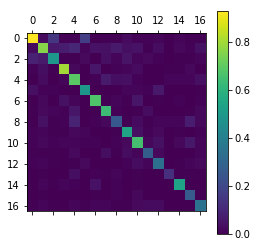

In [39]:
cnf_mat_norm = cnf_matrix/np.sum(cnf_matrix,axis=1)
plt.matshow(cnf_mat_norm)
plt.colorbar()
plt.show()

In [37]:
print(MSE (clf, X_train, Y_train))
print(MSE (clf, X_val, Y_val))
print(MSE (clf, X_test, Y_test))

0.731858683245
0.834639593163
0.845762068527


In [515]:
len(X_train), len(Y_train)


In [91]:
business_data[3]

{'address': '7014 Steubenville Pike',
 'attributes': ['AcceptsInsurance: False',
  'BusinessAcceptsCreditCards: True',
  "BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  'ByAppointmentOnly: True',
  "HairSpecializesIn: {'coloring': False, 'africanamerican': False, 'curly': False, 'perms': False, 'kids': False, 'extensions': False, 'asian': False, 'straightperms': False}",
  'RestaurantsPriceRange2: 3'],
 'business_id': 'cnGIivYRLxpF7tBVR_JwWA',
 'categories': ['Hair Removal',
  'Beauty & Spas',
  'Blow Dry\\/Out Services',
  'Hair Stylists',
  'Hair Extensions',
  'Massage',
  'Permanent Makeup',
  'Waxing',
  'Hair Salons'],
 'city': 'Oakdale',
 'hours': ['Tuesday 10:0-21:0',
  'Wednesday 10:0-21:0',
  'Thursday 10:0-21:0',
  'Friday 10:0-18:0',
  'Saturday 9:0-16:0'],
 'is_open': 1,
 'latitude': 40.4445439533,
 'longitude': -80.1745398943,
 'name': 'Plush Salon and Spa',
 'neighborhood': '',
 'postal_code': '15071',
 'review_co

In [487]:
punctuation = set(string.punctuation)
wordCount = defaultdict(int)
bigramCount = defaultdict(int)

def parse(review):
    return ''.join([c for c in review.lower() if not c in punctuation])
    
def process(review):
    r = parse(review)
    words = r.split()
    for w in words:
        wordCount[w]+=1
    for i in range(len(words) - 1):
        bigramCount[(words[i], words[i+1])]+=1
    return r;

def get_group_member_vector(review):
    feat = [0]*n_topics
    r = parse(review)
    words = r.split()
    for word in words:
        indices = topic_group[word]
        for index in indices:
            feat[index]+=1
    return feat;

In [491]:
topic_group['pet']

[35]

In [493]:
X = [get_group_member_vector(d['text']) for d in review_data if len(biz_cat_map[d['business_id']])>0]
X_train, Y_train, X_val, Y_val, X_test, Y_test = divide_shuffle(X, Y_cat)

In [498]:
clf = LogisticRegression(solver='sag', C=100, max_iter=500, random_state=42,multi_class='multinomial').fit(X_train, Y_train)

C:\Users\gopal\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [499]:
print("training score : %.3f (%s)" % (clf.score(X_train, Y_train), 'multinomial'))
print("val score : %.3f (%s)" % (clf.score(X_val, Y_val), 'multinomial'))
print("test score : %.3f (%s)" % (clf.score(X_test, Y_test), 'multinomial'))

training score : 0.639 (multinomial)
val score : 0.639 (multinomial)
test score : 0.632 (multinomial)


In [501]:
print(MSE (clf, X_train, Y_train))
print(MSE (clf, X_val, Y_val))
print(MSE (clf, X_test, Y_test))

1.22634785768
1.23928621977
1.25473027673


In [507]:
clf = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance').fit(X_train, Y_train)

In [508]:
top_n = 1000
print("training score : %.3f (%s)" % (clf.score(X_train[:top_n], Y_train[:top_n]), 'multinomial'))
print("val score : %.3f (%s)" % (clf.score(X_val[:top_n], Y_val[:top_n]), 'multinomial'))
print("test score : %.3f (%s)" % (clf.score(X_test[:top_n], Y_test[:top_n]), 'multinomial'))

training score : 0.986 (multinomial)
val score : 0.621 (multinomial)
test score : 0.599 (multinomial)


In [ ]:
print(MSE (clf, X_train, Y_train))
print(MSE (clf, X_val, Y_val))
print(MSE (clf, X_test, Y_test))

In [ ]:
print(MSE (clf, X_train, Y_train))
print(MSE (clf, X_val, Y_val))
print(MSE (clf, X_test, Y_test))

In [163]:
Y_cat_allhot=[]
for data in review_data:
    biz_id = data['business_id']
    biz_cat = biz_cat_map[biz_id]
    Y_re = []
    if len(biz_cat) > 0: 
        for i in range(len(sort_cat)):
            if sorted_cat[i] in biz_cat:
                Y_re.append(i)
        Y_cat_allhot.append(Y_re)

In [164]:
X_train, Y_train, X_test, Y_test = divide_shuffle(X, Y_cat_allhot)

In [141]:
biz_cat_map[review_data[43]['business_id']]
#review_data[0]['business_id']

['Nightlife', 'American (Traditional)', 'Pubs', 'Restaurants', 'Bars']

In [143]:
sorted_cat[43]

'Desserts'

In [165]:
Y_train = MultiLabelBinarizer().fit_transform(Y_train)
Y_test = MultiLabelBinarizer().fit_transform(Y_test)

In [168]:
classif = MultiOutputClassifier(LogisticRegression(solver='sag', max_iter=100, random_state=42))
classif.fit(X_train, Y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1)

In [169]:
print("training score : %.3f (%s)" % (classif.score(X_train, Y_train), 'multinomial'))
print("training score : %.3f (%s)" % (classif.score(X_test, Y_test), 'multinomial'))

training score : 0.092 (multinomial)
training score : 0.091 (multinomial)


In [171]:
classif.predict_proba([X_train[20]])

array([[[ 0.82633575,  0.87923616,  0.86589458,  0.97733154,  0.86372048,
          0.95819639,  0.9677954 ,  0.96677378,  0.96342583,  0.91872359,
          0.95905684,  0.96370821,  0.98184472,  0.99042375,  0.97702844,
          0.98915706,  0.98805733,  0.97693918,  0.9943677 ,  0.97875616,
          0.97105778,  0.98452812,  0.99076456,  0.97997014,  0.98687785,
          0.99105333,  0.99401241,  0.99382916,  0.99124485,  0.99042594,
          0.99848361,  0.98004279,  0.99173367,  0.97258035,  0.96499477,
          0.96848953,  0.98782307,  0.98585992,  0.98409357,  0.99796086,
          0.99688217,  0.99695169,  0.99659777,  0.99345461,  0.99666652,
          0.99836017,  0.99119312,  0.99270208,  0.98492456,  0.9982832 ],
        [ 0.17366425,  0.12076384,  0.13410542,  0.02266846,  0.13627952,
          0.04180361,  0.0322046 ,  0.03322622,  0.03657417,  0.08127641,
          0.04094316,  0.03629179,  0.01815528,  0.00957625,  0.02297156,
          0.01084294,  0.01194267,  0

In [116]:
Y_train[20]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [118]:
classif.coef_

array([[ 0.87594988,  0.27417891, -0.25144437, ...,  0.24344576,
        -0.05553205,  0.06420742],
       [-0.57857329,  0.11445075,  0.09737409, ..., -0.23982565,
         0.18851711, -0.24101246],
       [ 0.11852847,  0.15359837, -0.09695249, ...,  0.75237683,
        -0.09799886, -0.2556888 ],
       ..., 
       [-0.02202086,  0.28282802,  0.02113026, ..., -0.40713826,
         0.03446511,  0.05847888],
       [-0.41768068, -0.17112794,  0.12263567, ..., -0.19292094,
         0.1164748 , -0.16657292],
       [-0.24034207, -0.10851545,  0.06188289, ...,  0.04471868,
         0.18018434,  0.11913712]])

In [136]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

In [184]:
regr = RandomForestClassifier(n_estimators=40, oob_score = True)
regr.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [185]:
print("training score : %.3f (%s)" % (regr.score(X_train, Y_train), 'multinomial'))
print("training score : %.3f (%s)" % (regr.score(X_test, Y_test), 'multinomial'))

training score : 0.929 (multinomial)
training score : 0.095 (multinomial)


In [190]:
#K_NN
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
clf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')

In [ ]:
def train_loss(clf, X_train, Y_train):
    res = 0.0
    print ("total:" + str(len(X_train)))
    for i in range(len(X_train)):
        print(i)
        y_pred = clf.predict([X_train[i]])
        res+=(np.linalg.norm(y_pred-Y_train[i]))
    return res/len(Y_train)
train_loss(clf, X_train[], Y_train)

total:99819
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

In [198]:
#print("training score : %.3f (%s)" % (clf.score(X_train, Y_train), 'multinomial'))
#print("training score : %.3f (%s)" % (clf.score(X_test, Y_test), 'multinomial'))

In [ ]:
clf = neighbors.RadiusNeighborsClassifier(radius=2, weights='distance')
clf.fit(X_train, Y_train)